In [8]:
from sympy import S
from sympy.physics.wigner import clebsch_gordan
from sympy.physics.wigner import racah
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
import numpy as np
from __future__ import division
import scipy as sci
import scipy.special as sp
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import qmc
import os
import datetime
import time
import scipy.stats as sps
from multiprocessing import Pool
from itertools import repeat
import random
import math
from scipy.integrate import odeint
from IPython.display import display, clear_output,set_matplotlib_formats
import matplotlib.cm as cm
import matplotlib.ticker
import matplotlib.mlab as mlab
import sys
from scipy.stats import norm

#plt.style.use('science')
plt.rcParams.update({'font.size': 12})
gr = 4
h = 3

In [9]:
l_deform = 2
m_deform = 0
energy = 100
beta2 = 1.3
mass_target = 58.268
mass_coeff = mass_target**(1/3)

r_array = np.linspace(0, 20, 1000)

R0 = 1.2*mass_coeff

a0 =0.65

V0 = 40.0

hbarc = 197 # MeV • fm

In [10]:
# Define the potential function
def wood_saxon_potential(r):
    '''
    Input a grid of radial coordinates and output the optical potential at each point
    in the grid.
    '''
    R = R0
    return (- V0 / (1 + np.exp((r - R) / a0)))

# Deform the potential function with a spherical deformation
def wood_saxon_potential_deformed(r, theta, phi):
    '''
    From the previously defined angular momentum components of the deformation introduce a deformation
    parametrized by  "beta2"
    '''
    R = R0 - beta2*(sp.sph_harm(m_deform, l_deform, phi, theta))
    return - V0 / (1 + np.exp((r - R) / a0))




# Create a grid of points in 3D space
r = np.linspace(0, 20, 1000)
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 200)
r, theta, phi = np.meshgrid(r, theta, phi)

# Calculate the potential energy at each point in the grid (check that this works)
potential = wood_saxon_potential_deformed(r, theta, phi)

# Compare to regular spherical optical potential
undeformed_potential = wood_saxon_potential(r_array)

In [11]:
# Calculate the multipole moments using spherical harmonics
def calculate_multipole_moments(l_max, r_values):
    moments = {}
    '''
    Equation () of the report. Integrate out the angular dependencies of the spherical harmonics to obtain the 
    radial deformation. As inputs, the maximum multipole moment integrated and the radial grid of the interaction.
    The outputs will be the radial functions for each degree of multipole being integrated, as a dictionary. 
    '''
    for l in range(l_max + 1):
        for m in range(1):
            #for m in range(-l, l + 1):
            values = []
            for r in r_values:
                integrand_real = lambda theta, phi: wood_saxon_potential_deformed(r, theta, phi).real * sp.sph_harm(m, l, phi, theta).real * np.sin(theta)/(np.pi)*np.sqrt(np.pi/4)#*0.5/(2*np.pi)#*norm#*(4*np.pi)**(-1)*(2*l+1)**(1/2)
                integrand_imag = lambda theta, phi: wood_saxon_potential_deformed(r, theta, phi).imag * sp.sph_harm(m, l, phi, theta).imag * np.sin(theta)/(np.pi)*np.sqrt(np.pi/4)#*0.5/(2*np.pi)#*norm#*(4*np.pi)**(-1)*(2*l+1)**(1/2)
                result_real, _ = dblquad(integrand_real, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)
                result_imag, _ = dblquad(integrand_imag, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)
                values.append(result_real+1j*result_imag)
            moments[(l, m)] = (values)
            
    return moments

In [12]:
#run the integral function for a l_max and radial array
multipole_moments = calculate_multipole_moments(l_max=5, r_values=r_array)

#extract the radial functions with different multipole moments
V_mono = multipole_moments.get((0,0))
V_dip = multipole_moments.get((1,0))
V_quad = multipole_moments.get((2,0))
V_oct = multipole_moments.get((3,0))
V_ten = multipole_moments.get((4,0))

FileNotFoundError: [Errno 2] No such file or directory: 'monopole.txt'

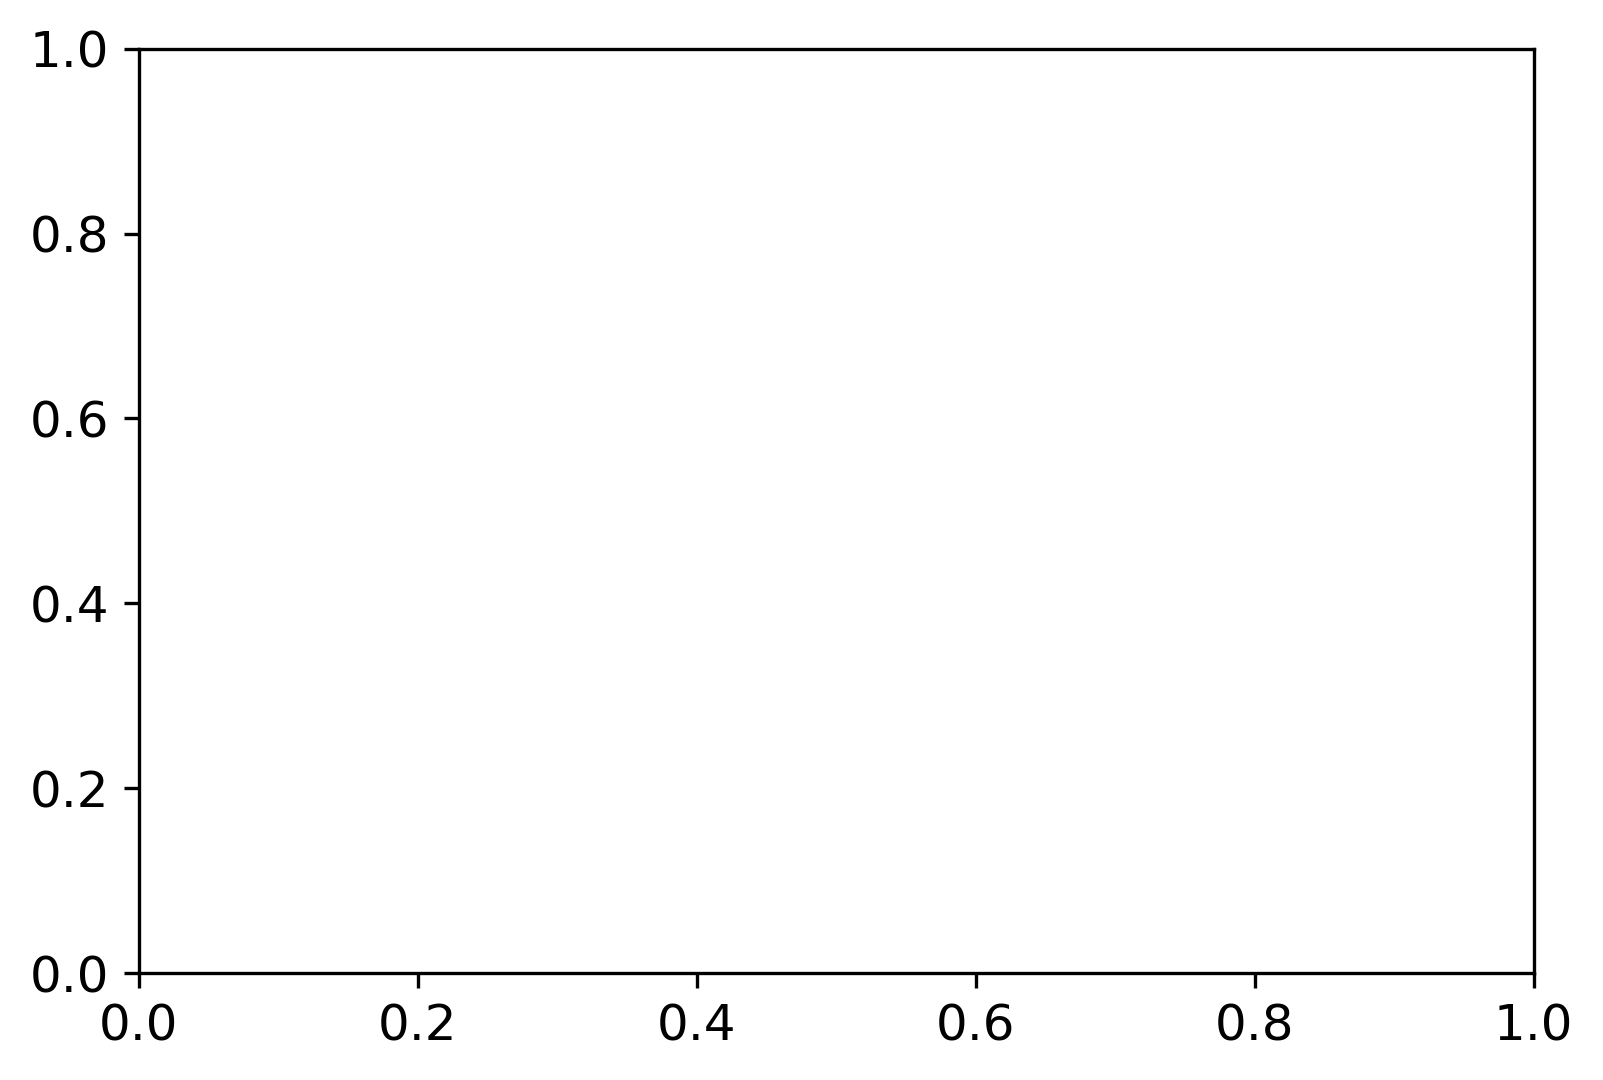

In [13]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['legend.fontsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

r_grid = np.linspace(0,20,1000)



#read in the monopole term from fresco   
x1 = []
y1 = []
f = open("monopole.txt")
for line in f:
    line = line.strip().split() 
    x1.append(float(line[0]))
    y1.append(float(line[1]))



#read in quadrupole term from fresco    
x2 = []
y2 = []
f = open("quadrupole.txt")
for line in f:
    line = line.strip().split() 
    x2.append(float(line[0]))
    y2.append(float(line[1]))

#compare to the ones extracted through the integral


ax.plot(x1,y1,label='fresco monopole')
ax.plot(x2,y2,label='fresco dipole')
ax.plot(r_grid,-np.abs(V_quad),linestyle='--',label='quadrupole')
ax.plot(r_grid,-np.abs(V_mono),linestyle='--',label='monopole')

#ax.set_yscale('log')
ax.set_xlabel(r'$r$(fm)')
ax.set_ylabel(r'V(r)')
ax.tick_params(width=1, length=4)
ax.legend()
fig.savefig(str("Fresco_comparison.png"))
plt.show

In [17]:
def hat(a):
    '''
    Just a function to compute normalzation coefficients of the Wigner-Eckhart theorem
    '''
    return np.sqrt(2*a+1)

In [18]:
def total_coupling_test(l_def_max,I_i,I_f,s,J):
    '''
    Equation () of the report. For a given maximum multipole moment integral l_def_max,
    for a given initial target spin I_i, for a gven final target spin I_f, projectile spin s 
    and total angular momentum J, perform loops over the allowed quantum numbers l,j,I,s, etc. 
    and compute the coupling coefficients. 
    '''
    J_tot_spin = {}
    
    
    
    #obtain the contributing j(ls) mininum and maximum for the entrance channel
    j_i_min = J - I_i
    j_i_max = J + I_i
    
    
    if j_i_min < 0:
        j_i_min = I_i - J
        j_i_max = I_i + J
    
    # find the number of j(ls) states that contribute to the entrance channel
    j_i_diff = int(j_i_max - j_i_min)
    
    
    #obtain the contributing j(ls) mininum and maximum for the exit channel
    j_f_min = J - I_f
    j_f_max = J + I_f
    
    if j_f_min < 0:
        j_f_min = I_f - J
        j_f_max = I_f + J
        
        
    # find the number of integers js that contribute to the exit channel
    j_f_diff = int(j_f_max - j_f_min)
    
    #loop over the angular moment integrals
    for q in range(l_def_max+1):
        
        #start the count over j components starting from the minimum j in the entrance channel
        i_count = j_i_min
        
        #loop over the number of j's in the entrance channel
        for i in range(j_i_diff+1):
    
            #start the count over j components starting from the minimum j in the exit channel
            j_count = j_f_min
            
            #loop over the number of j's in the exit channel
            for j in range(j_f_diff+1):
            
                
                #For each j(ls) of the entrance channel being looped over, calculate the min and max contributing 
                #relative angular momentums
                l_i_min = int(i_count - s)
                l_i_max = int(i_count + s)
                
                #For each j(ls) of the ext channel being looped over, calculate the contributing 
                #relative angular momentums
                l_f_min = int(j_count - s)
                l_f_max = int(j_count + s)
            
                
                #Loop over the min and max values of relative angular momentums in the entrance channel
                for l in range(l_i_min,l_i_max+1):
                    
                    #Loop over the min and max values of relative angular momentum in the exit channel
                    for k in range(l_f_min,l_f_max+1):
                        
                        #Loop over the internal initial target spin projectons K
                         for m in range(-I_i,I_i+1):
                                
                            #Loop over the interal final target spin projections K
                            for n in range(-I_f,I_f+1):
                                
                                #angular momentum coupling coefficients
                                coeff = (-1)**(q+s+n+2*i_count+J)*hat(l)*hat(k)*hat(i_count)*hat(j_count)\
                                *hat(I_i)*hat(I_f)* wigner_6j(j_count,i_count,q,I_i,I_f,J)\
                                *wigner_6j(j_count,i_count,q,l,k,s)*wigner_3j(l,k,q,0,0,0)\
                                *wigner_3j(I_i,I_f,q,m,-n,0)
                                
                                #if the coefficient obtained through the loops is not zero, 
                                #add as the dictionary key the values of angular momentum and the coupling
                                #coefficient value
                                if coeff != 0:
                                    J_tot_spin[(q,';',l,i_count,I_i,':',k,j_count,I_f,J)] = coeff
            
            
                #print(l_i_min,l_i_max)
                #print(l_f_min,l_f_max)
                #print(i_count,j_count)
                
                #add one value of j to the j_min of the exit channel
                j_count +=1
                
            #add one value of j to the j_min of the entrance channel
            i_count +=1

    #(Q;l,j,I_i:l',j',I_f,J)
    return J_tot_spin

In [19]:
couplings_dipole = total_coupling_test(2,0,2,0,2)
print(couplings_dipole)

{(2, ';', 2, 2, 0, ':', 0, 0, 2, 2): 0.0894427190999916*sqrt(5), (2, ';', 2, 2, 0, ':', 2, 2, 2, 2): -0.063887656499994*sqrt(14), (2, ';', 2, 2, 0, ':', 4, 4, 2, 2): 0.0383325938999964*sqrt(70)}
